In [1]:
from ast import literal_eval
from pandas import DataFrame  # http://github.com/pydata/pandas
import pandas as pd
import re
import requests               # http://github.com/kennethreitz/requests
import subprocess
import sys
import json
import glob
from os import path

In [2]:
import matplotlib as plt
#plt.style.use('ggplot')
%matplotlib inline

In [3]:
corpora = dict(eng_us_2012=17, eng_us_2009=5, eng_gb_2012=18, eng_gb_2009=6,
               chi_sim_2012=23, chi_sim_2009=11, eng_2012=15, eng_2009=0,
               eng_fiction_2012=16, eng_fiction_2009=4, eng_1m_2009=1,
               fre_2012=19, fre_2009=7, ger_2012=20, ger_2009=8, heb_2012=24,
               heb_2009=9, spa_2012=21, spa_2009=10, rus_2012=25, rus_2009=12,
               ita_2012=22)

In [17]:
def getNgrams(query, corpus, startYear, endYear, smoothing, caseInsensitive):
    params = dict(content=query, year_start=startYear, year_end=endYear,
                  corpus=corpora[corpus], smoothing=smoothing,
                  case_insensitive=caseInsensitive)
    if params['case_insensitive'] is False:
        params.pop('case_insensitive')
    if '?' in params['content']:
        params['content'] = params['content'].replace('?', '*')
    if '@' in params['content']:
        params['content'] = params['content'].replace('@', '=>')
    req = requests.get('http://books.google.com/ngrams/graph', params=params)
    res = re.findall('var data = (.*?);\\n', req.text)
    if res:
        data = {qry['ngram']: qry['timeseries']
                for qry in literal_eval(res[0])}
        df = DataFrame(data)
        df.insert(0, 'year', list(range(startYear, startYear+len(df))))
        df.set_index('year', inplace=True)
        df = df[list(filter(lambda x:"(All)" in x, df.columns))]
        df = df.rename(columns={x:x.split("(All)")[0] for x in df.columns})
    else:
        df = DataFrame()
    return req.url, params['content'], df

In [12]:
def word_freq(words1):
    q, word, df = getNgrams(words1[0], "eng_2012", 1800, 2010, True, True)

    for word in words1[1:]:
        q, word, df_ = getNgrams(word, "eng_2012", 1800, 2010, True, True)
        df = df.join(df_)
    return df

In [6]:
obj = json.load(open("data/NYT/NYT_bicultural.json"))
df = pd.DataFrame.from_records(obj["graph_data"][0]["data"])
df = df.rename(columns={"total_articles_published": "Total"})
database = df[["Total", "year"]]

for file in glob.glob("data/NYT/*json"):
  #if 'data/NYT/NYT_bicultural.json' in file: continue 
  obj = json.load(open(file))
  word = path.basename(file).split("_", 1)[1].split(".")[0]
  print(word)
  df = pd.DataFrame.from_records(obj["graph_data"][0]["data"])
  df.drop("total_articles_published", 1, inplace=True)
  df = df.rename(columns={"article_matches": word})
  database = pd.merge(database, df, on="year", how="outer")

database.set_index("year", inplace=True)
values = (database.values.T / database.Total.values).T
values[:, 0] = database.Total.values
nyt_norm = pd.DataFrame(data=values, columns=database.columns, index=database.index)

multiculturalism
mixed_race
bicultural
biethnic
cultural_pluralism
polyethnic
polyracial
other ethnicity
biracial
monocultural
multicultural
polyculturalism
polycultural
monoracial
multiracial
other race
mixed ethnicity
multiethnic
interracial


In [22]:
def plot_both(words):
    df1 = word_freq(words) 
    axis_1 = df1.plot(style={w:"-" for w in words})
    axis_1.set_ylabel("Google Book Ngrams ($\%$)")
    axis_1.set_xlabel("Year")
    _ = axis_1.legend(loc='upper left', ncol=2)
    axis_1.ticklabel_format(style="sci")
    axis_1.grid(True)

    axis_2 = axis_1.twinx()
    axis_2 = nyt_norm[words].plot(ax=axis_2, figsize=(14,6), style={w:":" for w in words})
    axis_2.set_ylabel("New York Times ($\%$)")
    axis_2.ticklabel_format(style="sci")
    _ = axis_2.legend(loc='upper right', ncol=2)
# Change the style, Roxanne does not like pretty things!

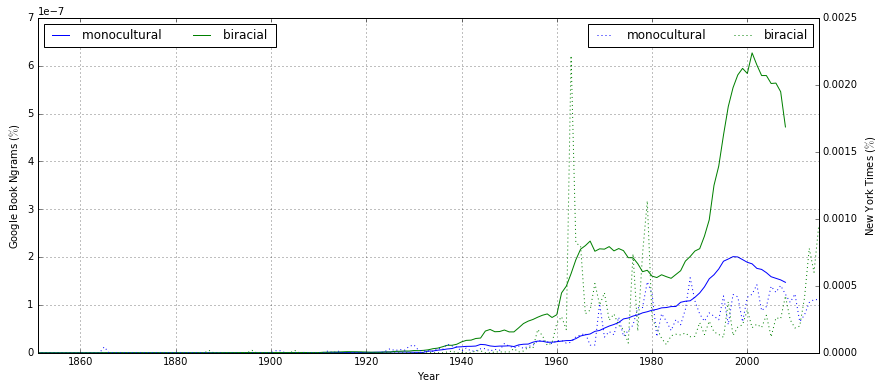

In [23]:
plot_both(['monocultural', 'biracial'])

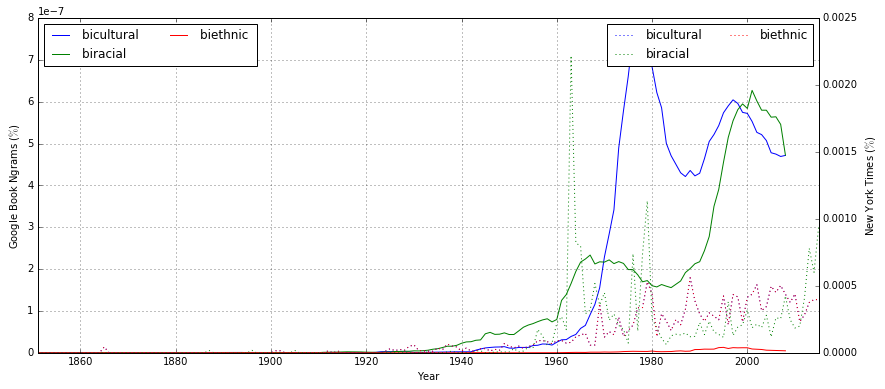

In [24]:
plot_both(['bicultural', 'biracial', 'biethnic'])

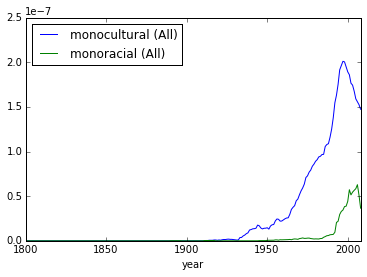

In [6]:
df1 = word_freq(['monocultural', 'monoracial']) 
df1.plot()

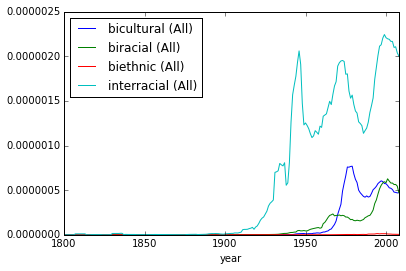

In [7]:
df2 = word_freq(['bicultural', 'biracial', 'biethnic', 'interracial'])
df2.plot()

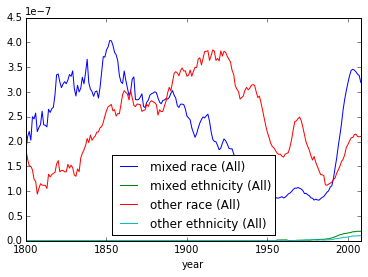

In [8]:
df3 = word_freq(['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity'])
df3.plot()

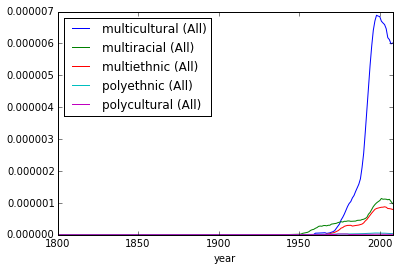

In [9]:
df4 = word_freq(['multicultural', 'multiracial', 'multiethnic', 'polyracial', 'polyethnic', 'polycultural'])
df4.plot()

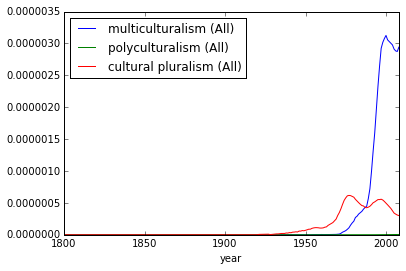

In [10]:
df5 = word_freq(['multiculturalism', 'polyculturalism', 'cultural pluralism'])
df5.plot()